In [110]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# multithreading and showing progress
import concurrent.futures
from tqdm import tqdm

# image processing
import pydicom
import cv2

In [232]:
# train paths
train_csv_path = '../data/stage_1_train.csv'
train_image_folder_original = '../data/stage_1_train_images/'
train_image_folder_target = '../data/stage_1_train_images_jpg/'

# test paths
test_csv_path = '../data/stage_1_sample_submission.csv'
test_image_folder_original = '../data/stage_1_test_images/'
test_image_folder_target = '../data/stage_1_test_images_jpg/'

In [118]:
def get_image_list(csv_path, image_folder_original, image_folder_target):

    # load list from CSV
    image_list = pd.read_csv(csv_path)

    # drop 'Label' column
    image_list.drop(columns=['Label'],inplace=True)
    
    # standardize the ID to format ID_{number}
    image_list.ID = image_list.ID.map(lambda id: 'ID_' + id.split('_')[1])
 
    # drop duplicates keeping only unique IDs
    image_list.drop_duplicates(subset='ID',inplace=True)
    
    # reset index after dropping duplicated
    image_list.reset_index(drop=True,inplace=True)
 
    # add origin and target paths for each image
    image_list['origin'] = image_list.ID.map(lambda id: image_folder_original + id + '.dcm')
    image_list['target'] = image_list.ID.map(lambda id: image_folder_target + id + '.png')

    return image_list

image_list = get_image_list(train_csv_path,train_image_folder_original,train_image_folder_target)

In [46]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    if rescale:
        # Extra rescaling to 0-1, not in the original notebook
        img = (img - img_min) / (img_max - img_min)
    
    return img

def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [113]:
def get_image_resized(img_path):
    """Output windowed and resized jpg of dcm image"""

    ds=pydicom.dcmread(img_path)
    raw=ds.pixel_array
    window_center , window_width, intercept, slope = get_windowing(ds)
    windowed = window_image(raw, 50, 100, intercept, slope)
    resized = cv2.resize(windowed, (200, 200))
    X.append(resized)
    return resized

In [238]:
def get_image(img_path):
    """Output three versions of image - raw, windowed and resized"""
    ds=pydicom.dcmread(img_path)
    raw=ds.pixel_array
    window_center , window_width, intercept, slope = get_windowing(ds)
    windowed = window_image(raw, 50, 100, intercept, slope)
    resized = cv2.resize(windowed, (200, 200))
    X.append(resized)
    return raw,windowed,resized

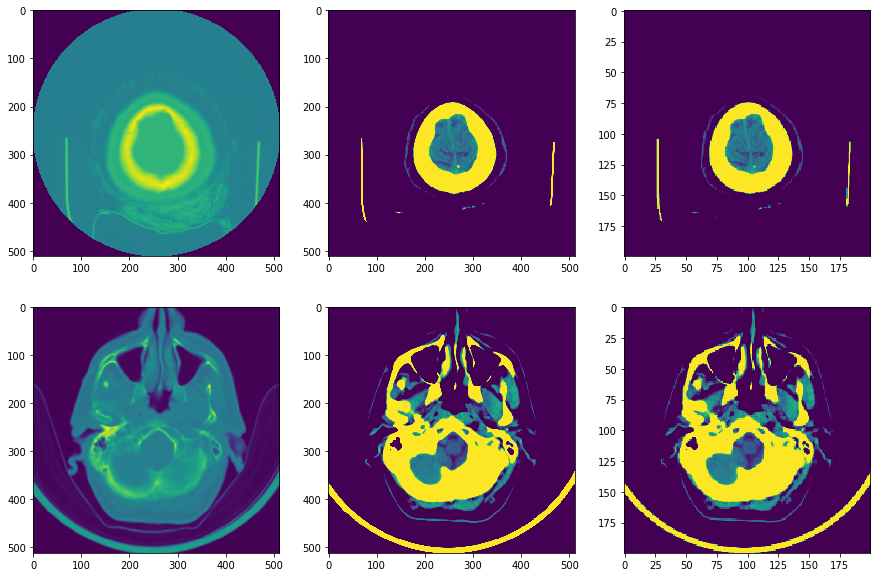

In [116]:
def display_image_processing(
    image_paths = False, 
    n_images = 5, 
    random_state=12345,
    bone_color = True,
    **kwargs):
    """Display the versions of each image
    Version:
    1. raw
    2. windowed
    3. windowed and reduced

    Keyword arguments:
    image_paths (list of strings) - image paths 
    n_images (int) - number of different images to display
    random_state (int) - random state for image selection
    
    Output:
    display (inline image) - images displayed inline
    image_paths (list) - list of image paths
    bone_color (bool) - if true, pass cmap=plt.cm.bone to plt.imshow()
    """
    if not image_paths:
        image_paths = list(image_list.origin.sample(
            n=n_images,
            replace=False,
            random_state=12345))
        # print(image_paths)
    nrow = len(image_paths)
    ncol = 3

    fig = plt.figure(figsize=(15,5*nrow))
    for row in range(0,nrow):
        img_list = list( get_image(image_paths[row]) )

        for sub_img in range(0,3):
            fig.add_subplot(nrow,ncol,row*3+sub_img+1)
            if bone_color:
                plt.imshow(img_list[sub_img],cmap=plt.cm.bone,**kwargs)
            else:
                plt.imshow(img_list[sub_img],**kwargs)
    #         fig.add_subplot()
    return image_paths
paths = display_image_processing(n_images=2, random_state=12, bone_color=False)

In [233]:
# fig = plt.figure(figsize=(15,10))
# plt.imshow(get_image_resized(image_list.origin[350]),cmap=plt.cm.bone)
# plt.show()

In [237]:
def save_as_jpg_train(image_id,
                image_folder_original ='../data/stage_1_train_images/', 
                image_folder_target='../data/stage_1_train_images_jpg/'): 
    img = get_image_resized(image_folder_original+image_id+'.dcm')
    cv2.imwrite(image_folder_target+image_id+'.png',img)

def save_as_jpg_test(image_id,
                image_folder_original ='../data/stage_1_test_images/', 
                image_folder_target='../data/stage_1_test_images_jpg/'): 
    img = get_image_resized(image_folder_original+image_id+'.dcm')
    cv2.imwrite(image_folder_target+image_id+'.jpg',img)

def run_thread(f, iterable):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        executor.map(f, iterable, chunksize=50)

In [ ]:

# convert all stage 1 train images with multithreading
# image_list = get_image_list(train_csv_path,train_image_folder_original,train_image_folder_target)
# image_list_ids = image_list['ID']
# run_thread(save_as_jpg_train, image_list_ids)
# print('stage 1 train complete')

# convert all stage 1 test images with multithreading
# image_list = get_image_list(test_csv_path,test_image_folder_original,test_image_folder_target)
# image_list_ids = image_list['ID']
# run_thread(save_as_jpg_test, image_list_ids)
# print('stage 1 test complete')